# Basic `alphatools` workflow

1. load data and meta data
2. basic minimal preprocessing
3. perform PCA
4. plot PCA embeddings, variance and loadings

In [ ]:
%load_ext autoreload
%autoreload 2

import logging
from anndata import AnnData
import numpy as np
import pandas as pd

import alphatools as at
from alphatools.pl.figure import create_figure, label_axes
from alphatools.pl.plots import Plots
from alphatools.pp.embeddings import pca
from alphatools.pp.metadata import add_core_proteome_mask

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data 

Dataset taken from datashare folder: https://datashare.biochem.mpg.de/s/sSYkOj22kM5AJ4O

In [ ]:
#### Chagne after merging, and use Lucas' code to load the DIA-NN data

# load protein groups into an AnnData object with index & columns as obs & var
url_data = "https://datashare.biochem.mpg.de/s/sSYkOj22kM5AJ4O/download?path=%2FSearch%20results%2FDIA-NN%201.9.2&files=report.pg_matrix.tsv"
df = pd.read_csv(url_data, sep="\t")

url_metadata = "https://datashare.biochem.mpg.de/s/sSYkOj22kM5AJ4O/download?path=%2F&files=simple_metadata.csv"
md = pd.read_csv(url_metadata, sep=",")

adata = AnnData(
    X=df.drop(columns=["Protein.Group", "Protein.Names", "Genes", "First.Protein.Description"]).to_numpy().T,
    obs=md,
    var=df[["Protein.Group", "Protein.Names", "Genes", "First.Protein.Description"]].set_index("Protein.Group"),
)

# overview of the data object
print(adata)

AnnData object with n_obs × n_vars = 18 × 4954
    obs: 'filename', 'replicate', 'fraction'
    var: 'Protein.Names', 'Genes', 'First.Protein.Description'


/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Basic EDA on a synthetic example dataset:

1. Generate example data
2. Filter for data completeness on sample level
3. Visualize samples as histograms
4. Save data

### Filter by data completeness:

Remove features which have more than the allowed fraction of missing values

In [ ]:
print("The numeric data in the anndata object:")
display(adata.to_df().head())

print("The sample-level metadata in the anndata object:")
display(adata.obs.head())

print("The feature-level metadata in the anndata object:")
display(adata.var.head())

#  filter out features with more than 25 % missing values
print("Before filtering, the shape of the anndata object: ", adata.shape)
adata = at.pp.filter_data_completeness(adata=adata, max_missing=0.25)
print("After filtering, the shape of the anndata object: ", adata.shape)

print("The numeric data in the anndata object:")
display(adata.to_df().head())

print("The sample-level metadata in the anndata object:")
display(adata.obs.head())

print("The feature-level metadata in the anndata object:")
display(adata.var.head())

The numeric data in the anndata object:


Protein.Group,A0A024R1R8;Q9Y2S6,A0A0B4J2F0,A0A0J9YX75;A0A0J9YXY3;P0DPF7,A0AV96,A0FGR8,A0JLT2,A0PJW6,A1L0T0,A1L390,A1X283,...,Q9Y6N5,Q9Y6N6,Q9Y6N7,Q9Y6N8,Q9Y6R0,Q9Y6V7,Q9Y6W5,Q9Y6X3,Q9Y6X9,Q9Y6Y8
0,9506220.0,9930580.0,NaN,6414570.0,29546900.0,NaN,19563300.0,23059400.0,1346120.0,11691800.0,...,39051400.0,172419.0,6796840.0,8998980.0,NaN,NaN,5111880.0,NaN,NaN,7060290.0
1,25866000.0,NaN,NaN,18604800.0,18958500.0,3202770.0,NaN,14090600.0,790375.0,23128600.0,...,10291200.0,NaN,3829290.0,NaN,574729.0,19405500.0,6310680.0,10867000.0,11684000.0,13398300.0
2,10150200.0,11627800.0,NaN,6550420.0,28679800.0,NaN,19387300.0,24248100.0,963907.0,9263040.0,...,38928800.0,NaN,5441930.0,9034600.0,1026870.0,NaN,3963610.0,NaN,NaN,6189950.0
3,14660600.0,8741560.0,NaN,9638120.0,35471700.0,NaN,15716300.0,36269500.0,NaN,11779400.0,...,33905400.0,237138.0,5068170.0,7413300.0,965536.0,NaN,4858220.0,NaN,NaN,6046510.0
4,23477900.0,1497570.0,NaN,16496400.0,27413400.0,NaN,2334540.0,24950500.0,NaN,21687600.0,...,8834620.0,187094.0,3736040.0,4581280.0,1516620.0,NaN,7919380.0,NaN,NaN,9935580.0


The sample-level metadata in the anndata object:


,filename,replicate,fraction
0,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map2,3K
1,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,12K
2,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,1K
3,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,24K
4,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,3K


The feature-level metadata in the anndata object:


,Protein.Names,Genes,First.Protein.Description
Protein.Group,,,
A0A024R1R8;Q9Y2S6,TMA7B_HUMAN;TMA7_HUMAN,TMA7;TMA7B,Translation machinery-associated protein 7B
A0A0B4J2F0,PIOS1_HUMAN,PIGBOS1,Protein PIGBOS1
A0A0J9YX75;A0A0J9YXY3;P0DPF7,TVB62_HUMAN;TVB63_HUMAN;TVB69_HUMAN,TRBV6-2;TRBV6-3;TRBV6-9,T cell receptor beta variable 6-9
A0AV96,RBM47_HUMAN,RBM47,RNA-binding protein 47
A0FGR8,ESYT2_HUMAN,ESYT2,Extended synaptotagmin-2


INFO:root:pp.filter_data_completeness(): Dropped 2123 / 4954 features with >0.25 missing in any group.


Before filtering, the shape of the anndata object:  (18, 4954)
After filtering, the shape of the anndata object:  (18, 2831)
The numeric data in the anndata object:


Protein.Group,A0A024R1R8;Q9Y2S6,A0AV96,A0FGR8,A1L0T0,A1X283,A5PLL7,A5YKK6,A6NCE7;Q9GZQ8,A6NDG6,A6NHR9,...,Q9Y6K5,Q9Y6M0,Q9Y6M1,Q9Y6M4,Q9Y6M5,Q9Y6N7,Q9Y6N8,Q9Y6R0,Q9Y6W5,Q9Y6Y8
0,9506220.0,6414570.0,29546900.0,23059400.0,11691800.0,2741150.0,10835800.0,5629360.0,561137.0,3789200.0,...,8955980.0,27799800.0,3070990.0,3151630.0,64329500.0,6796840.0,8998980.0,NaN,5111880.0,7060290.0
1,25866000.0,18604800.0,18958500.0,14090600.0,23128600.0,4624200.0,11243600.0,7728880.0,462468.0,47274600.0,...,9021290.0,18298000.0,NaN,1579620.0,38458300.0,3829290.0,NaN,574729.0,6310680.0,13398300.0
2,10150200.0,6550420.0,28679800.0,24248100.0,9263040.0,3809220.0,10480100.0,7059070.0,700098.0,NaN,...,7307580.0,23668700.0,3084110.0,3130200.0,60378200.0,5441930.0,9034600.0,1026870.0,3963610.0,6189950.0
3,14660600.0,9638120.0,35471700.0,36269500.0,11779400.0,5127720.0,19063600.0,8905940.0,582714.0,NaN,...,12709900.0,39207800.0,6057120.0,3672700.0,56567800.0,5068170.0,7413300.0,965536.0,4858220.0,6046510.0
4,23477900.0,16496400.0,27413400.0,24950500.0,21687600.0,5740560.0,39849800.0,8597510.0,595144.0,3586450.0,...,18124000.0,30144100.0,10509100.0,3353660.0,42608500.0,3736040.0,4581280.0,1516620.0,7919380.0,9935580.0


The sample-level metadata in the anndata object:


,filename,replicate,fraction
0,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map2,3K
1,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,12K
2,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,1K
3,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,24K
4,20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_1...,Map1,3K


The feature-level metadata in the anndata object:


,Protein.Names,Genes,First.Protein.Description
Protein.Group,,,
A0A024R1R8;Q9Y2S6,TMA7B_HUMAN;TMA7_HUMAN,TMA7;TMA7B,Translation machinery-associated protein 7B
A0AV96,RBM47_HUMAN,RBM47,RNA-binding protein 47
A0FGR8,ESYT2_HUMAN,ESYT2,Extended synaptotagmin-2
A1L0T0,HACL2_HUMAN,ILVBL,2-hydroxyacyl-CoA lyase 2
A1X283,SPD2B_HUMAN,SH3PXD2B,SH3 and PX domain-containing protein 2B


## Creating new layers prior to preprocessing

This way, we can save the raw data and try different pp steps on the raw data.

In [ ]:
# we assume that the data is already log2 transformed
adata.layers["raw"] = adata.X.copy()

# log2 transform the data
adata.X = np.log2(adata.X + 1)

### Visualize the distribution of values in different levels of an observational metadata variable

In this example, check the distribution of "gene_1" expression values per cell type.

INFO:root:Column 'A1L0T0' found in: data.var_names. Using that
INFO:root:Column 'A1L0T0' found in: data.var_names. Using that
INFO:root:Column 'replicate' found in: data.obs.columns. Using that


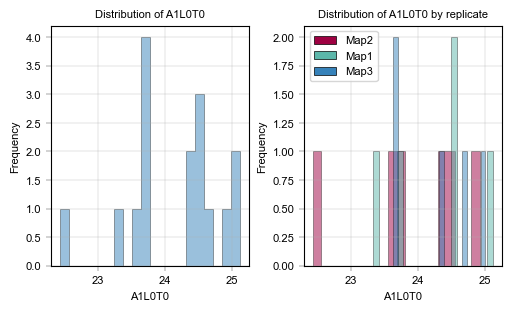

In [ ]:
# Apply the AxisManager to make axes iterable and apply consistent AlphaTools styling.
# Axes can also be accessed directly by indexing the axm object.
fig, axm = create_figure(nrows=1, ncols=2, figsize=(5, 3))

# Plot.histogram handles adata natively. Columns from the data and metadata are accessible
# Focus on the distribution of protein A1L0T0
ax = axm.next()
Plots.histogram(
    data=adata,
    value_column="A1L0T0",
    bins=20,
    legend="auto",
    ax=ax,
    hist_kwargs={"alpha": 0.5, "histtype": "stepfilled", "linewidth": 0.5, "edgecolor": "black"},
)
label_axes(ax, "A1L0T0", "Frequency", "Distribution of A1L0T0")

# Focus on the distribution of protein A1L0T0 in the different replicates
ax = axm.next()
Plots.histogram(
    data=adata,
    value_column="A1L0T0",
    color_map_column="replicate",
    bins=20,
    legend="auto",
    ax=ax,
    hist_kwargs={"alpha": 0.5, "histtype": "stepfilled", "linewidth": 0.5, "edgecolor": "black"},
)
label_axes(ax, "A1L0T0", "Frequency", "Distribution of A1L0T0 by replicate")

# # save figure
# save_figure(
#     fig=fig,
#     filename="sample_histogram.png",
#     output_dir=output_directory,
#     dpi=300,
#     transparent=False,
# )

### Running PCA

PCA can not be computed on matrices with missing values. Therefore, prior to PCA, we will create a list of 'core proteins' of proteins detected in all observations, save it in the feature meta data frame (adata.var) and run PCA on the shortlisted proteins. 

In [ ]:
# add a new column to the adata.var object with the name "isCore" to indicate whether the feature is part of the core proteome
add_core_proteome_mask(adata, layer="raw", new_column_name="is_core")

# view hoe many features are part of the core proteome
print("The number of features in the core proteome:")
print(adata.var["is_core"].value_counts())

# run PCA on the data
# this function is now implemented on sample level (PCA of the observations).
pca(adata, meta_data_mask_column_name="is_core", n_comps=10)

# view the PCA results
print("The dimensions of PC coordinates in the adata.obsm are (n_obs x n_comp):")
print(adata.obsm["X_pca_obs"].shape)
print("The PCA loadings in the adata.varm are (n_var x n_comp):")
print(adata.varm["PCs_obs"].shape)
print("Ratio of explained variance (n_comp):")
print(adata.uns["variance_pca_obs"]["variance_ratio"])
print("The explained variance (n_comp):")
print(adata.uns["variance_pca_obs"]["variance"])


# Now run PCA on the protein space to get their projection in the PCA space.
pca(adata, meta_data_mask_column_name="is_core", n_comps=10, dim_space="var")

# view the PCA results for features
print("----- PCA ON FEATURES -----")
print("The dimensions of PC coordinates in the adata.varm are (n_obs x n_comp):")
print(adata.varm["X_pca_var"].shape)
print("The PCA loadings of the samples in the adata.obsm are (n_var x n_comp):")
print(adata.obsm["PCs_var"].shape)
print("Ratio of explained variance (n_comp):")
print(adata.uns["variance_pca_var"]["variance_ratio"])
print("The explained variance (n_comp):")
print(adata.uns["variance_pca_var"]["variance"])

INFO:alphatools.pp.metadata:Adding core proteome mask to feature metadata
INFO:alphatools.pp.metadata:'is_core' column added to data.var to classify core proteins
INFO:alphatools.pp.embeddings:computing PCA
INFO:alphatools.pp.embeddings:computing PCA


The number of features in the core proteome:
is_core
True     1806
False    1025
Name: count, dtype: int64
The dimensions of PC coordinates in the adata.obsm are (n_obs x n_comp):
(18, 10)
The PCA loadings in the adata.varm are (n_var x n_comp):
(2831, 10)
Ratio of explained variance (n_comp):
[0.56593504 0.33056594 0.06844902 0.01339105 0.00388991 0.00288049
 0.0023081  0.00220095 0.00194543 0.0017315 ]
The explained variance (n_comp):
[1009.50632405  589.65850994  122.09831939   23.88675892    6.93875425
    5.13817412    4.11715411    3.92601867    3.47022027    3.08861607]
----- PCA ON FEATURES -----
The dimensions of PC coordinates in the adata.varm are (n_obs x n_comp):
(2831, 10)
The PCA loadings of the samples in the adata.obsm are (n_var x n_comp):
(18, 10)
Ratio of explained variance (n_comp):
[8.07567317e-01 1.13818512e-01 6.33157115e-02 8.74927065e-03
 2.21018860e-03 7.89962453e-04 5.76627224e-04 4.64255895e-04
 4.48561680e-04 3.63473757e-04]
The explained variance (n_comp)

### Plot the PCA results 

INFO:root:Column 'replicate' found in: data.obs.columns. Using that


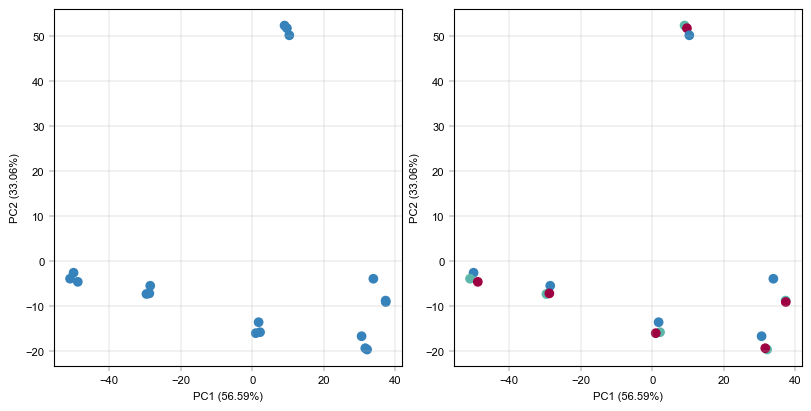

In [ ]:
fig, axm = create_figure(1, 2, figsize=(8, 4))
ax = axm.next()

Plots.plot_pca(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=2,
    dim_space="obs",
    label=False,
    label_column=None,
    embbedings_name=None,
)

ax = axm.next()
# color the points by replicate
Plots.plot_pca(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=2,
    label=False,
    label_column=None,
    embbedings_name=None,
    color_map_column="replicate",
)

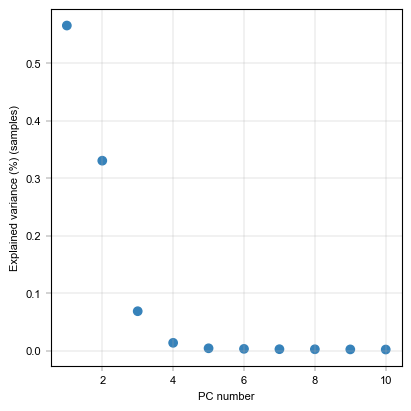

In [ ]:
fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()
Plots.scree_plot(adata=adata, ax=ax, n_pcs=50)

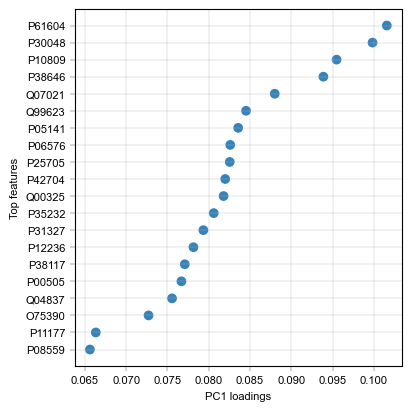

In [ ]:
fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()
Plots.plot_pca_loadings(
    data=adata,
    ax=ax,
    dim=1,
    nfeatures=20,
)

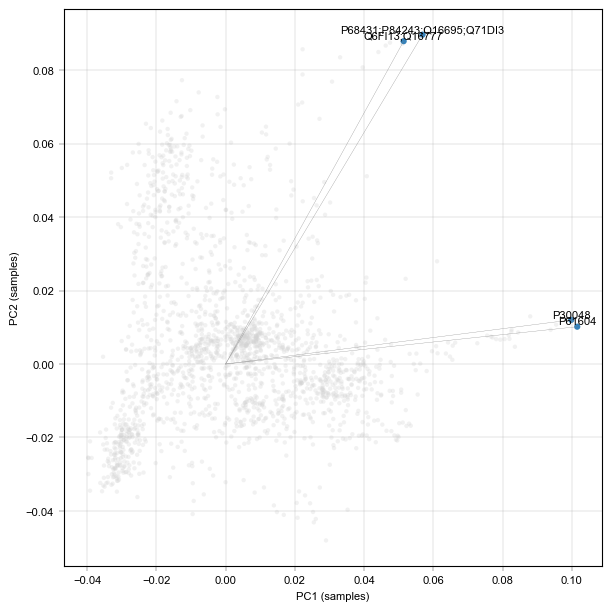

In [ ]:
# Plot the PCA loadings for 2 PCs in 2D (this helps in identifying the features that contribute most to the PC plot)
fig, axm = create_figure(1, 1, figsize=(6, 6))
ax = axm.next()

Plots.plot_pca_loadings_2d(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=2,
    nfeatures=2,
    add_labels=True,
    add_lines=True,
    scatter_kwargs=None,
)

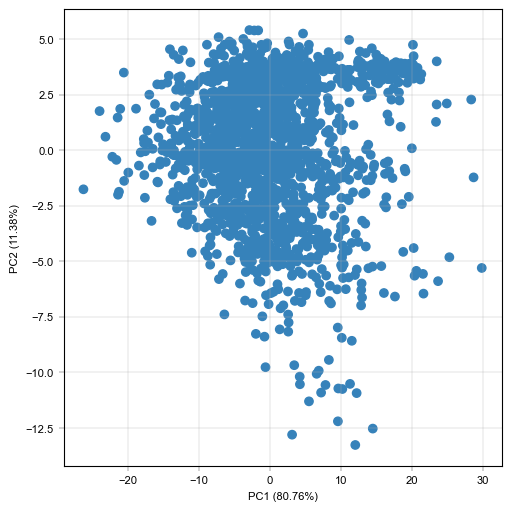

In [ ]:
# now produce the PCAs plot for the features
fig, axm = create_figure(1, 1, figsize=(5, 5))
ax = axm.next()

Plots.plot_pca(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=2,
    dim_space="var",
    label=False,
    label_column=None,
    embbedings_name=None,
)

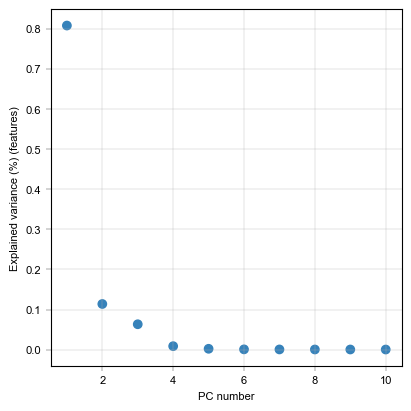

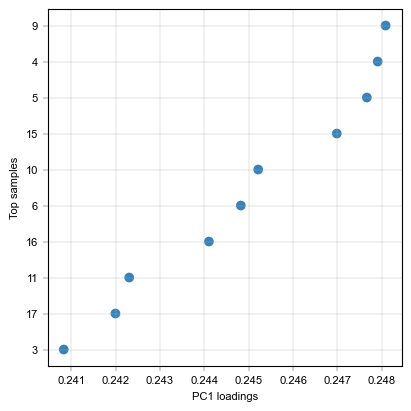

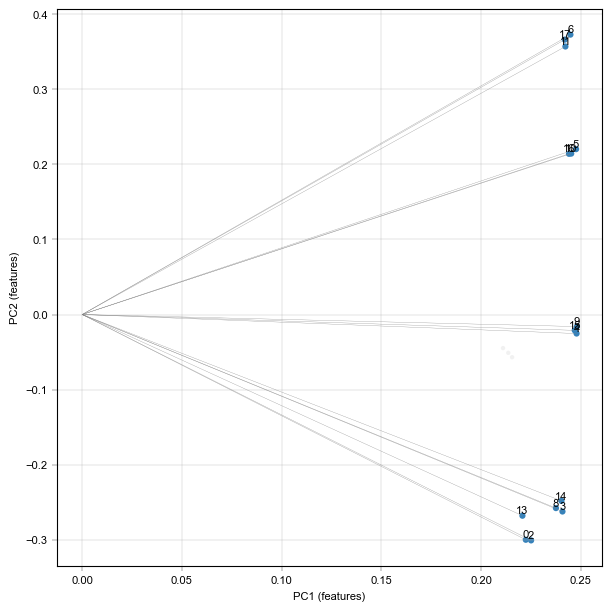

In [ ]:
fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()
Plots.scree_plot(adata=adata, ax=ax, n_pcs=50, dim_space="var")

fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()
Plots.plot_pca_loadings(data=adata, ax=ax, dim=1, nfeatures=10, dim_space="var")


fig, axm = create_figure(1, 1, figsize=(6, 6))
ax = axm.next()

Plots.plot_pca_loadings_2d(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=2,
    nfeatures=10,
    add_labels=True,
    add_lines=True,
    scatter_kwargs=None,
    dim_space="var",
)